In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

### Question 1

In [2]:
def integrate_and_fire_with_exc(T, delta_cs_init, us_spiketimes, cs_spikestimes, cm = 10.0, gL = 1.0, E_L = -70.0, Eex = 0, V_th = -54, V_reset = -80, tau_gexc = 5.0, A_LTP = 0.35, A_LTD = 0.4, tau_LTP = 25, tau_LTD = 35, delta_us = 1.2, dt = 0.1):

    V = E_L 
    g_exc = 0 
    delta_cs = delta_cs_init
    Vs, gs, delta_css, spikes = [], [], [], []

    pre_spiketime = -np.inf 
    post_spiketime = -np.inf

    time = np.arange(0, T, dt)

    for i, t in enumerate(time):
        
        if np.isclose(t, us_spiketimes, atol = dt/2).any():
            g_exc += delta_us

        # Check for CS presentation
        if np.isclose(t, cs_spikestimes, atol = dt/2).any():
            g_exc += delta_cs
            pre_spiketime = t
            delta_t_LTD = t - post_spiketime
            delta_cs -= A_LTD * np.exp(-delta_t_LTD / tau_LTD)
            delta_cs = max([delta_cs, 0])


        dg = (-g_exc / tau_gexc) * dt 
        g_exc += dg 
        
        dV = ((-gL * (V - E_L) - g_exc * (V - Eex)) / cm) * dt 
        V += dV

        if V >= V_th:
            Vs[i-1] = 50
            V = V_reset
            spikes.append(t)
            post_spiketime = t
            delta_t_LTP = t - pre_spiketime
            delta_cs += A_LTP * np.exp(-delta_t_LTP / tau_LTP)
            delta_cs = min([delta_cs, 1.2])

        Vs.append(V)
        gs.append(g_exc)
        delta_css.append(delta_cs)

    return time, np.array(Vs), np.array(gs), np.array(delta_css), np.array(spikes)

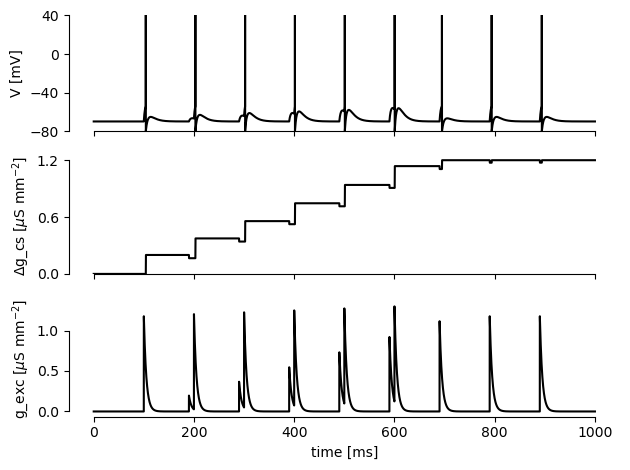

In [3]:
T = 1000
us_times_1 = np.array([100, 200, 300, 400, 500, 600])
cs_times_1 = np.array([90, 190, 290, 390, 490, 590, 690, 790, 890])
time, V1, gs1, delta_CS1, spikes1 = integrate_and_fire_with_exc(T, 0.0, us_times_1, cs_times_1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True)

ax1.plot(time, V1, c = 'k')
ax1.set_ylabel('V [mV]')
ax1.set_ylim(-80, 40)
ax1.set_yticks([-80, -40, 0, 40])

ax2.plot(time, delta_CS1, c = 'k')
ax2.set_ylabel(r'$\Delta$g_cs [$\mu$S mm$^{-2}$]')
ax2.set_ylim([0, 1.22])
ax2.set_yticks([0, 0.6, 1.2])

ax3.plot(time, gs1, c = 'k')
ax3.set_ylabel(r'g_exc [$\mu$S mm$^{-2}$]')
ax3.set_xlabel('time [ms]')

sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw3_question1a.pdf')

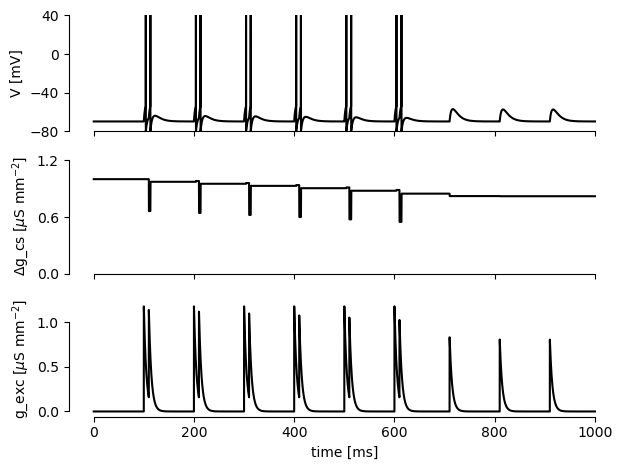

In [4]:
us_times_2 = np.array([100, 200, 300, 400, 500, 600])
cs_times_2 = np.array([110, 210, 310, 410, 510, 610, 710, 810, 910])
time, V2, gs2, delta_CS2, spikes2 = integrate_and_fire_with_exc(T, 1.0, us_times_2, cs_times_2)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True)

ax1.plot(time, V2, c = 'k')
ax1.set_ylabel('V [mV]')
ax1.set_ylim(-80, 40)
ax1.set_yticks([-80, -40, 0, 40])

ax2.plot(time, delta_CS2, c = 'k')
ax2.set_ylabel(r'$\Delta$g_cs [$\mu$S mm$^{-2}$]')
ax2.set_ylim([0, 1.22])
ax2.set_yticks([0, 0.6, 1.2])

ax3.plot(time, gs2, c = 'k')
ax3.set_ylabel(r'g_exc [$\mu$S mm$^{-2}$]')
ax3.set_xlabel('time [ms]')

sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw3_question1b.pdf')

### Question 2 

In [5]:
def noisy_integrate_and_fire(sigma, timesteps, dt = 0.001, tau = 10, E_L = -70, V_th = -54, V_reset = -80):
    """
    Implementation of a noisy integrate and fire neuron. 
    """

    time = np.arange(0, timesteps, dt) 
    Vs, spikes = [], []

    V = E_L
    Vs.append(E_L)
    
    for i in range(1, len(time)):
        E_eff = -56 + sigma * np.sqrt(2 * tau / dt) * np.random.normal()
        dv = ((-V + E_eff) / tau) * dt
        V += dv 

        if V >= V_th:
            Vs[i-1] = 50
            V = V_reset
            spikes.append(1)
            
        Vs.append(V)
       
    return time, Vs, spikes 

In [ ]:
tau_dep = 0.3 # s
tau_fac = 0.1 # s

P0_dep = 1 
P0_fac = 0 

dt = 0.001  # s
T = 1.0     # s 
time = np.arange(0, T, dt)

def generate_spikes(rate, dt, time):
    return np.random.rand(len(time)) < rate * dt

def probability_simulation(rate, time = time, dt = dt, P0_dep = P0_dep, P0_fac = P0_fac, tau_dep = tau_dep, tau_fac = tau_fac, burst = False):

    spikes = generate_spikes(rate, dt, time)

    if burst:
        spikes[:] = False
        spikes[(time >= 0.5) & (time < 0.6)] = generate_spikes(100, dt, time[(time >= 0.5) & (time < 0.6)])

    P_dep = np.zeros_like(time)
    P_fac = np.zeros_like(time)
    P_dep[0] = P0_dep
    P_fac[0] = P0_fac

    transmission_dep, transmission_fac = [], []

    for i in range(1, len(time)):

        dP_dep = ((P0_dep - P_dep[i - 1]) / tau_dep) * dt
        dP_fac = ((P0_fac - P_fac[i - 1]) / tau_fac) * dt 

        P_dep[i] = P_dep[i - 1] + dP_dep
        P_fac[i] = P_fac[i - 1] + dP_fac

        if spikes[i]:
            if np.random.rand() < P_dep[i]:
                transmission_dep.append(time[i])
                P_dep[i] = 0

            P_fac[i] += 0.1 * (1 - P_fac[i])
            if np.random.rand() < P_fac[i]:
                transmission_fac.append(time[i])
    return spikes, P_dep, P_fac, transmission_dep, transmission_fac  


def plot_results(spikes, P_dep, P_fac, transmission_dep, transmission_fac, rate):
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex = True, height_ratios = [0.2, 0.4, 0.4])

    axs[0].scatter(transmission_fac, [1.5 for _ in range(len(transmission_fac))], color = 'r', marker = '|', s = 100, label = 'facilitating transmission')
    axs[0].scatter(transmission_dep,[0.75 for _ in range(len(transmission_dep))], marker = '|', s = 100, label = 'depressing transmission', color = 'b')

    axs[0].scatter(spikes, [0 for _ in range(len(spikes))], marker = '|', s = 100, label = 'presynaptic', color = 'k')
    axs[0].legend(frameon = False)
    axs[0].set_yticks([])                           
    axs[0].spines['left'].set_visible(False)        
    axs[0].get_yaxis().set_visible(False)         


    axs[1].plot(time, P_dep, 'b')
    axs[1].set_ylabel("P of depressing synapse")
    axs[1].set_ylim([0, 1.01])
    
    axs[2].plot(time, P_fac, 'r')
    axs[2].set_ylabel("P of facilitating synapse")
    axs[2].set_ylim([0, 1])
    axs[2].set_xlabel("Time (s)")
    
    sns.despine(trim = True)
    plt.tight_layout()
    plt.savefig(f'hw3_{rate}.pdf')

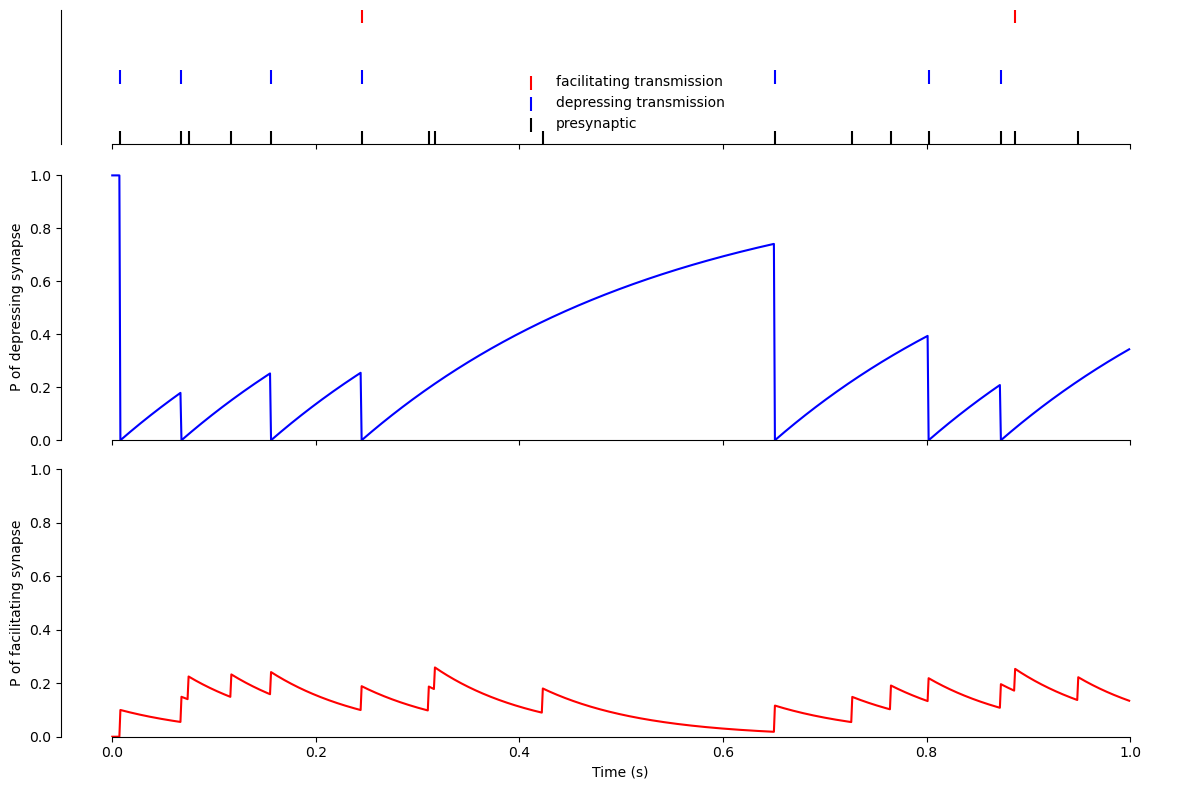

In [7]:
spikes, P_dep, P_fac, trans_dep, trans_fac = probability_simulation(10)
spikes = time[np.where(spikes == 1)]
plot_results(spikes, P_dep, P_fac, trans_dep, trans_fac, 10)

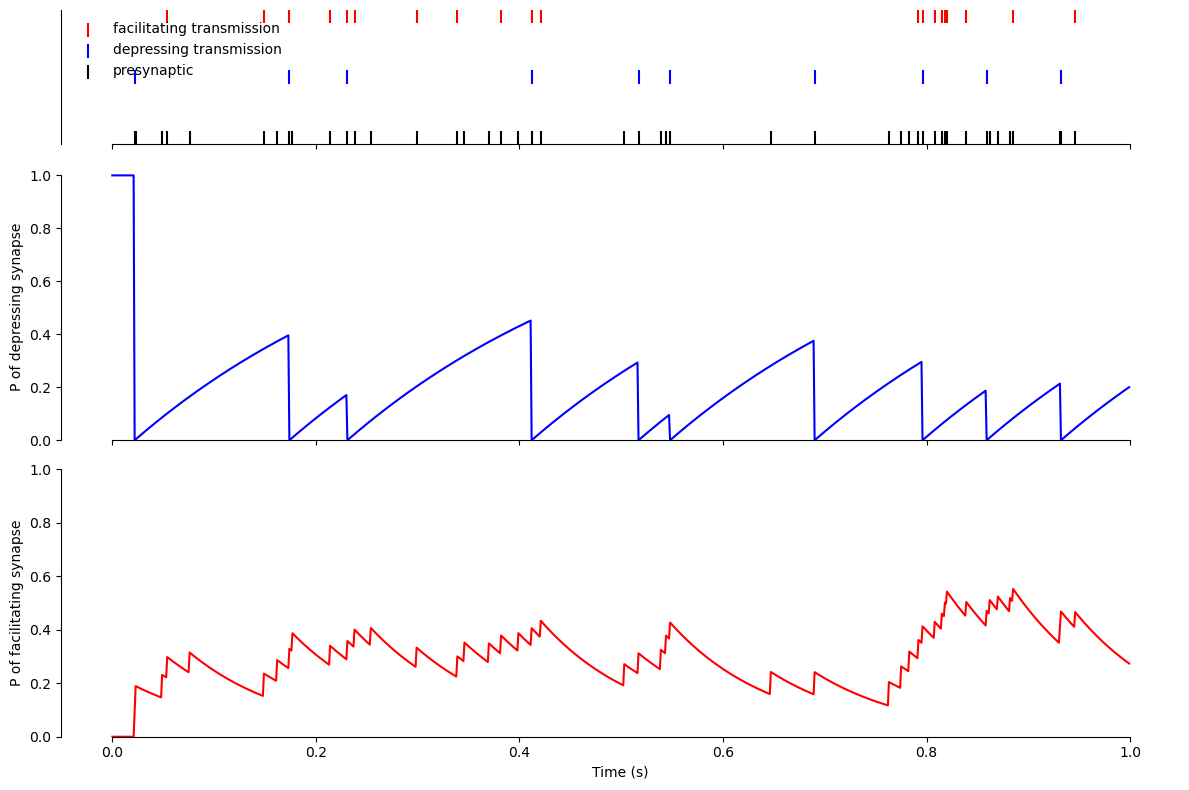

In [8]:
spikes, P_dep, P_fac, trans_dep, trans_fac = probability_simulation(50)
spikes = time[np.where(spikes == 1)]
plot_results(spikes, P_dep, P_fac, trans_dep, trans_fac, 50)

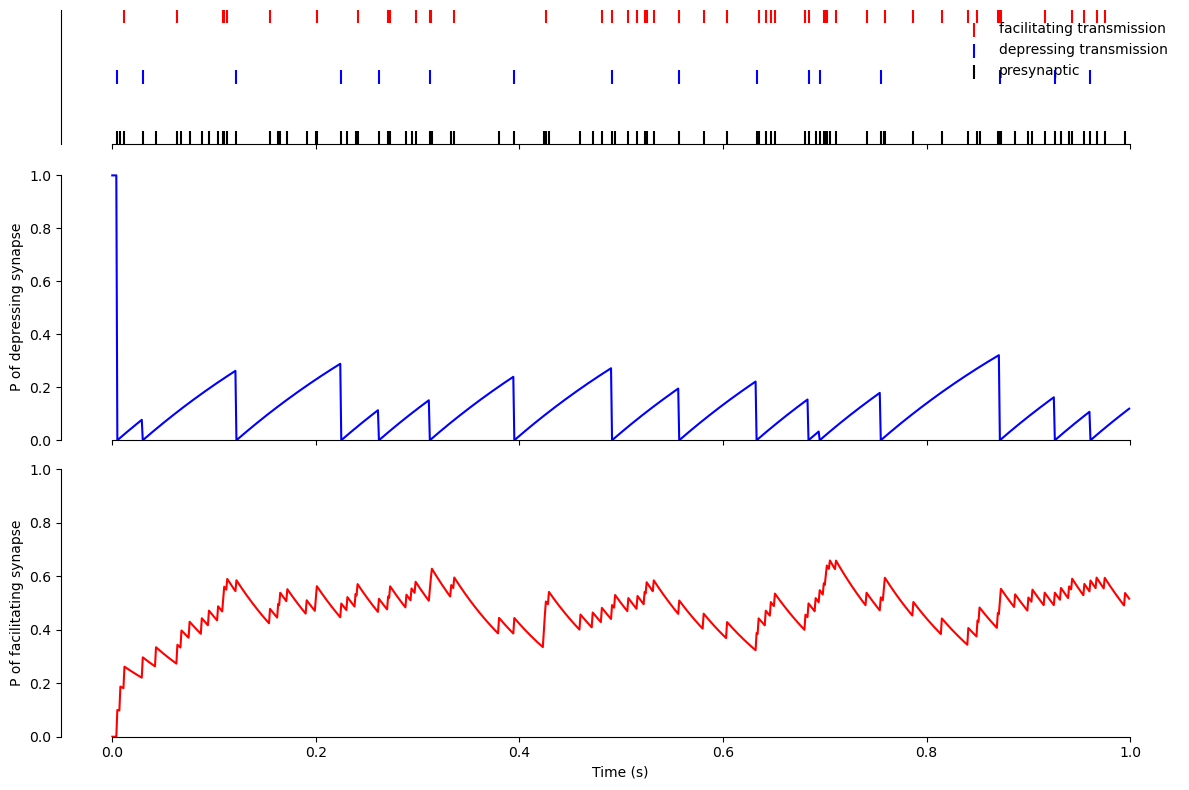

In [9]:
spikes, P_dep, P_fac, trans_dep, trans_fac = probability_simulation(100)
spikes = time[np.where(spikes == 1)]
plot_results(spikes, P_dep, P_fac, trans_dep, trans_fac, 100)

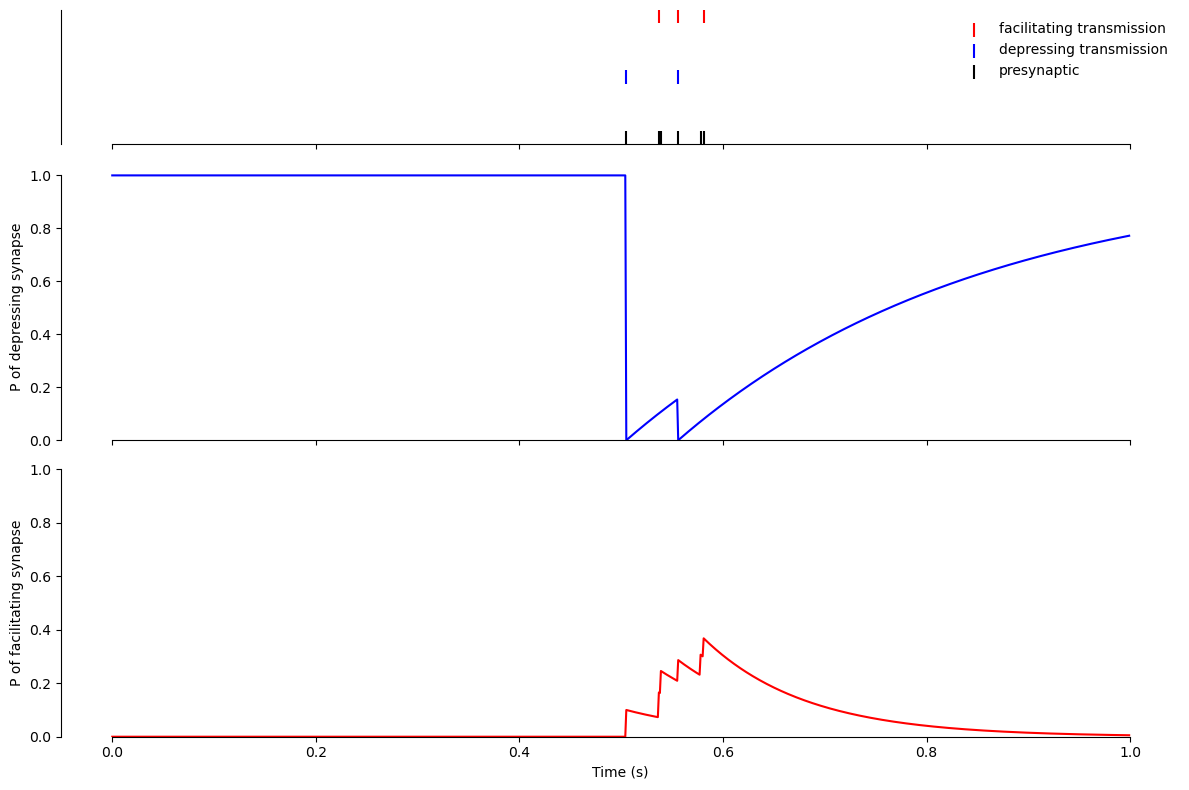

In [10]:
spikes, P_dep, P_fac, trans_dep, trans_fac = probability_simulation(100, burst = True)
spikes = time[np.where(spikes == 1)]
plot_results(spikes, P_dep, P_fac, trans_dep, trans_fac, 'burst_100')

In [11]:
rates = np.arange(0, 101, 5)
trans_rate_dep = []
trans_rate_fac = []

dt = 0.001  # s
T = 100.0     # s 
time = np.arange(0, T, dt)

for r in rates:
    total_dep = 0
    total_fac = 0
    spikes, trans_dep, trans_fac, _, _ = probability_simulation(r)
    total_dep += np.sum(trans_dep)
    total_fac += np.sum(trans_fac)
    trans_rate_dep.append(total_dep / T)
    trans_rate_fac.append(total_fac / T)


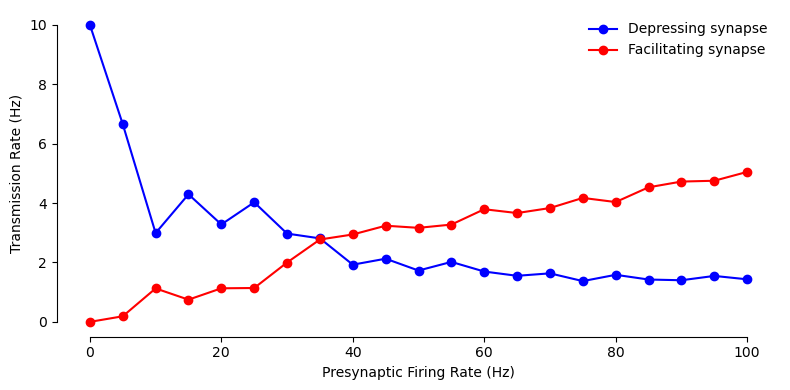

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(rates, trans_rate_dep, 'bo-', label='Depressing synapse')
plt.plot(rates, trans_rate_fac, 'ro-', label='Facilitating synapse')
plt.xlabel("Presynaptic Firing Rate (Hz)")
plt.ylabel("Transmission Rate (Hz)")
plt.legend(frameon = False)
sns.despine(trim = True)
plt.tight_layout()
plt.savefig(f'hw3_transmission_vs_firing_rate.pdf')